# wandb 튜토리얼 하고 깃헙에 올리기

1. [x] 깃헙 저장소 만들어서 연결하기
2. [x] 로스함수 그래프 train, validation 겹쳐지게 그리기
  - [ ] 겹치게 그리기 불가능, 두개의 Run 객체를 하나에 script에 어떻게?
3. [x] matplot 이용해서 이미지 그리기
  - https://wandb.ai/lavanyashukla/visualize-predictions/reports/Visualize-Model-Predictions--Vmlldzo1NjM4OA
4. [x] PIL image, HTML
5. [x] hyperparams parallel coordinate 그려보기
6. [ ] 내용 깃헙 리드미에 정리

In [1]:
import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: sang-hyun (use `wandb login --relogin` to force relogin)


True

In [3]:
import math
import random as R

for run in range(5):
    wandb.init(
        project = "basic-intro-with-name",
        name = f"experiment_{run}",
        config = {
            "learning_rate" : 0.02,
            "architecture" : "CNN",
            "dataset" : "CIFAR-100"
        }
    )
    
    offset = R.random()
    
    for x in range(50):
        acc = 0.16 * (math.log(1 + x + R.random()) + R.random() + offset)
        loss = 1 - 0.16 * (math.log(1 + x + R.random()) + R.random() + offset)
        wandb.log({"acc":acc, "loss":loss})

wandb.finish()

acc,0.79651
loss,0.29032
_runtime,1
_timestamp,1631207161
_step,49


acc,▁▁▂▁▃▂▄▃▄▄▅▅▆▅▆▆▆▆▆▆▅▅▅▅▆▆▆▇▅▇▆▆▆▇▆█▆▇▆█
loss,█▇▅▅▄▅▅▅▅▅▃▃▃▃▃▃▄▃▂▂▃▃▂▃▂▂▂▂▃▁▂▃▂▁▁▂▂▂▂▂
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


acc,0.75971
loss,0.18559
_runtime,1
_timestamp,1631207166
_step,49


acc,▂▂▁▂▂▅▄▃▅▄▄▅▅▆▆▅▇▅▇▅▇▇▇▇▆▆▇▆▇▆▆██▆▇██▇█▇
loss,███▆▆▄▅▄▄▄▄▄▄▃▄▃▃▄▄▄▄▂▂▂▂▃▂▂▃▁▁▁▂▁▁▂▂▃▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


acc,0.9243
loss,0.19002
_runtime,2
_timestamp,1631207172
_step,49


acc,▁▂▂▃▄▃▄▄▅▄▄▄▅▄▆▅▅▆▆▅▆▆▇▇▇▆▆▇▇▇▆▇█▆▆██▇██
loss,███▆▅▅▅▅▅▄▄▅▄▃▄▄▄▃▄▂▃▃▃▂▃▂▂▃▃▂▃▃▂▁▁▂▁▂▁▂
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


acc,0.77028
loss,0.15272
_runtime,1
_timestamp,1631207177
_step,49


acc,▁▂▂▃▄▄▄▄▄▅▅▅▆▅▅▅▆▆▅▇▇▇▆▇▆▇▇▇▆▆▆▇▆▇▇█▇██▇
loss,██▇▇▆▅▄▄▄▄▄▃▄▄▃▃▄▄▃▃▄▄▃▂▃▃▃▃▂▃▃▃▂▃▂▁▁▁▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


acc,0.84564
loss,0.09079
_runtime,2
_timestamp,1631207183
_step,49


acc,▁▂▃▃▃▃▄▄▅▆▅▄▄▅▅▆▆▆▆▆▇▇▅▇▇▆▆▆▆▇▆▇▇██▇█▇██
loss,█▇▆▅▅▆▆▅▅▅▃▅▃▄▄▄▄▃▃▃▂▃▃▃▃▃▂▂▂▁▃▃▁▃▂▂▂▃▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [4]:
!pip install plotly

In [5]:
import matplotlib.pyplot as plt

fibonacci = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
plt.plot(fibonacci)
plt.ylabel('some interesting numbers')

# Initialize run
wandb.init(
    project = "matplotlib-fibonacci"
)

# Log plot object
wandb.log({"plot": plt})

wandb.finish()

_runtime,1
_timestamp,1631207189
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [6]:
# Initialize run
wandb.init(
    project = "matplotlib-subplots"
)

fibonacci = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
fig, ax = plt.subplots(1, 2, figsize=(10,16))

randint_list = []
for i in range(50):

    ax[0].plot(fibonacci)
    ax[0].set_title('fibonacci')

    randint_list.append(R.randint(-10,10))

    ax[1].plot(randint_list)
    ax[1].set_title('randint [-10, 10]')

    # Log plot object
    wandb.log({"plot": fig})

wandb.finish()

_runtime,9
_timestamp,1631207202
_step,49


_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


_runtime,1
_timestamp,1631207207
_step,0


_runtime,▁
_timestamp,▁
_step,▁


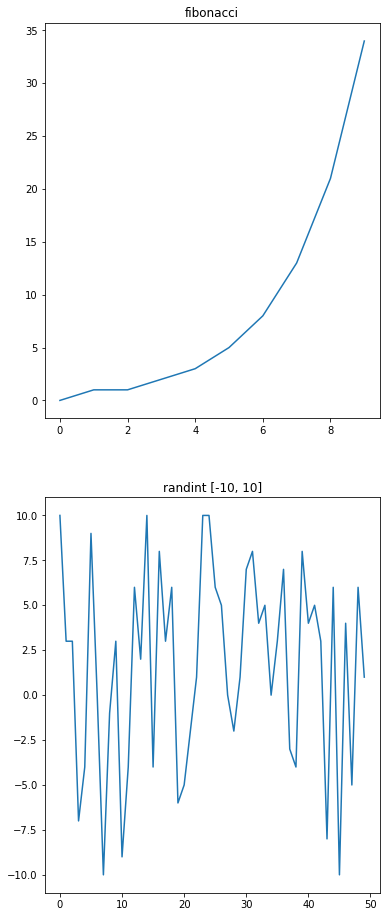

In [7]:
import PIL


# Initialize run
wandb.init(
    project = "matplotlib-subplots"
)

fibonacci = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
fig, ax = plt.subplots(2, 1, figsize=(6,16))

ax[0].plot(fibonacci)
ax[0].set_title('fibonacci')


randint_list = []
for i in range(50):
    randint_list.append(R.randint(-10,10))

ax[1].plot(randint_list)
ax[1].set_title('randint [-10, 10]')

fig.savefig('image.png')

img = PIL.Image.open('image.png')

# Log plot object
wandb.log({"img": [wandb.Image(img, caption = "Fibonacci and randint")]})

wandb.finish()

In [8]:
path_to_html = "some_html.html"

# Initialize run
wandb.init(project = "HTML")

# Log plot HTML
# As a file
#wandb.log({"custom_file": wandb.Html(open(path_to_html))})

# Inline

#html_str = r'<a href="https://mysite">Link</a>'

#wandb.log({"custom_string": wandb.Html(html_str)})

# Disable default styles
wandb.log({"custom_file": wandb.Html(open("some_html.html"), inject=False)})

wandb.finish()

_runtime,2
_timestamp,1631207213
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [9]:
sweep_config = {
  "name" : "my-sweep",
  "method" : "random",
  "parameters" : {
    "epochs" : {
      "values" : [10, 20, 50]
    },
    "learning_rate" :{
      "min": 0.0001,
      "max": 0.1
    }
  }
}

In [10]:
sweep_id = wandb.sweep(sweep_config, project="sweep-test")

Create sweep with ID: 0y8k56su
Sweep URL: https://wandb.ai/sang-hyun/sweep-test/sweeps/0y8k56su


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

class make_model(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def set_optim(self):
        self.optimizer = \
        optim.SGD(self.parameters(),
                  lr=self.config["learning_rate"], momentum=0.9)
        self.criterion = nn.CrossEntropyLoss()
    
    
    def fit(self, X, y):
        
        pred = self.forward(X)
        
        loss = self.criterion(pred, y)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss


In [14]:
def train():
    with wandb.init() as run:
        config = wandb.config
        model = make_model(config)
        model.set_optim()
        for epoch in range(config["epochs"]):
            for X,y in trainloader:
                loss= model.fit(X, y)  # your model training code here
                break
            wandb.log({"loss": loss, "epoch": epoch})

In [15]:
count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: zg9qlm4y with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.04621656455630391


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



loss,2.29697
epoch,9
_runtime,2
_timestamp,1631207221
_step,9


loss,▄▆▆▆▆▇▁▂█▅
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 736l05i8 with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08928865412646453


loss,2.41127
epoch,9
_runtime,3
_timestamp,1631207229
_step,9


loss,▄▄▄▁▅▃▆▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▁▁▁▁▁▁█
_timestamp,▁▁▁▁▁▁▁▁▁█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 42fdk3yd with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06696259735396301


loss,2.39293
epoch,9
_runtime,3
_timestamp,1631207236
_step,9


loss,▁▁▃▁▃▂▆▆▄█
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▁▁▁▁▁▁█
_timestamp,▁▁▁▁▁▁▁▁▁█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zd9rj783 with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.00818162194121223


loss,2.36201
epoch,49
_runtime,4
_timestamp,1631207244
_step,49


loss,▂▄▅▅▆▄▄▅▄▂▆▁▆▇▇▃▅▇▅▁█▅█▄▂▆▄▃▇█▆▆▆▃▄▄▆▃▆▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4daelok3 with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.029124436118875767


loss,2.30575
epoch,9
_runtime,3
_timestamp,1631207252
_step,9


loss,█▁▂▁▃▂▂▃▃▂
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▁▁▁▁▁██
_timestamp,▁▁▁▁▁▁▁▁██
_step,▁▂▃▃▄▅▆▆▇█


In [16]:
print("done")

done
